In [2]:
!git clone https://github.com/ignacio-ave/ADA-Portafolio.git



fatal: destination path 'ADA-Portafolio' already exists and is not an empty directory.


In [17]:
import os

def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print('{}{}'.format(subindent, f))
            
# Uso de la función en el directorio actual
list_files('.')


./
    jupyter.log
    .config/
        config_sentinel
        .last_update_check.json
        default_configs.db
        .last_survey_prompt.yaml
        active_config
        .last_opt_in_prompt.yaml
        gce
        logs/
            2023.08.14/
                13.34.30.262322.log
                13.33.33.197366.log
                13.33.57.660824.log
                13.34.31.051112.log
                13.33.07.436302.log
                13.34.05.095796.log
        configurations/
            config_default
    ADA-Portafolio/
        LICENSE
        .git/
            config
            HEAD
            index
            description
            packed-refs
            info/
                exclude
            branches/
            hooks/
                pre-push.sample
                pre-rebase.sample
                push-to-checkout.sample
                update.sample
                commit-msg.sample
                pre-commit.sample
                fsmonitor-watchman.sample

In [21]:
# Importamos las bibliotecas necesarias
import numpy as np
import struct

# Funciones para cargar los datos MNIST
def load_images(filename):
    with open(filename, "rb") as f:
        data = f.read()
        _, num_images, rows, cols = struct.unpack(">IIII", data[:16])
        images = np.frombuffer(data[16:], dtype=np.uint8).reshape(num_images, rows * cols)
        images = images.astype(np.float32) / 255.0  # Normalización
    return images

def load_labels(filename):
    with open(filename, "rb") as f:
        data = f.read()
        _, num_labels = struct.unpack(">II", data[:8])
        labels = np.frombuffer(data[8:], dtype=np.uint8)
    return labels

# Cargamos los datos de entrenamiento y de prueba

# /content/ADA-Portafolio/Backpropagation/MNIST DATABASE
path = input("Ingrese la ruta de la carpeta MNIST DATABASE: ")
X_train = load_images(path+"/train-images.idx3-ubyte")
y_train = load_labels(path+"/train-labels.idx1-ubyte")
X_test = load_images(path+"/t10k-images.idx3-ubyte")
y_test = load_labels(path+"/t10k-labels.idx1-ubyte")

# Convertimos las etiquetas a representación one-hot
num_classes = 10
y_train_one_hot = np.eye(num_classes)[y_train]
y_test_one_hot = np.eye(num_classes)[y_test]

# Verificamos las dimensiones de los datos
X_train.shape, y_train_one_hot.shape, X_test.shape, y_test_one_hot.shape


((60000, 784), (60000, 10), (10000, 784), (10000, 10))

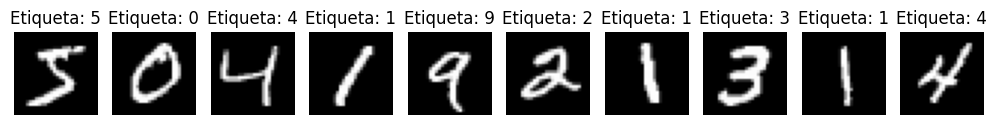

In [24]:
import matplotlib.pyplot as plt

def visualizar_imagenes(imagenes, etiquetas, num_muestras=10):
    """
    Visualiza un conjunto de imágenes con sus respectivas etiquetas.
    
    :param imagenes: Array de imágenes
    :param etiquetas: Array de etiquetas
    :param num_muestras: Número de muestras que se quieren visualizar
    """
    fig, axes = plt.subplots(1, num_muestras, figsize=(10, 2))
    
    for i, ax in enumerate(axes):
        # Redimensionar la imagen de (784,) a (28, 28)
        imagen = imagenes[i].reshape(28, 28)
        ax.imshow(imagen, cmap='gray')
        ax.set_title(f'Etiqueta: {etiquetas[i]}')
        ax.axis('off')
        
    plt.tight_layout()
    plt.show()

# Visualizar algunas imágenes del conjunto de entrenamiento
visualizar_imagenes(X_train, y_train)


In [25]:
# Definición e inicialización de la red neuronal usando NumPy

# Tamaño de las capas
input_size = 784  # Capa de entrada (28 * 28 píxeles)
hidden_size = 128  # Capa oculta con 128 unidades
output_size = 10   # Capa de salida (10 clases)

# Inicialización de los pesos y biases
np.random.seed(42)  # Semilla para reproducibilidad
W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2. / input_size)
b1 = np.zeros((1, hidden_size))
W2 = np.random.randn(hidden_size, output_size) * np.sqrt(2. / hidden_size)
b2 = np.zeros((1, output_size))

# Funciones de activación y sus derivadas
def relu(Z):
    return np.maximum(0, Z)

def relu_derivative(Z):
    return (Z > 0).astype(Z.dtype)

def softmax(Z):
    expZ = np.exp(Z - np.max(Z))
    return expZ / expZ.sum(axis=1, keepdims=True)

# Función de pérdida de Entropía Cruzada Categórica
def cross_entropy_loss(Y_true, Y_pred):
    m = Y_true.shape[0]
    loss = -np.sum(Y_true * np.log(Y_pred + 1e-8)) / m
    return loss

def cross_entropy_loss_derivative(Y_true, Y_pred):
    return Y_pred - Y_true

# Forward Propagation
def forward_propagation(X):
    Z1 = np.dot(X, W1) + b1
    A1 = relu(Z1)
    Z2 = np.dot(A1, W2) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

# Backward Propagation
def backward_propagation(X, Y, Z1, A1, Z2, A2):
    m = X.shape[0]
    
    dZ2 = cross_entropy_loss_derivative(Y, A2)
    dW2 = np.dot(A1.T, dZ2) / m
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m
    
    dZ1 = np.dot(dZ2, W2.T) * relu_derivative(Z1)
    dW1 = np.dot(X.T, dZ1) / m
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m
    
    return dW1, db1, dW2, db2

# Actualización de los pesos y biases
def update_parameters(dW1, db1, dW2, db2, learning_rate):
    global W1, b1, W2, b2
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2

# Entrenamiento de la red neuronal
def train(X, Y, learning_rate=0.1, epochs=100):
    loss_history = []
    for epoch in range(epochs):
        Z1, A1, Z2, A2 = forward_propagation(X)
        loss = cross_entropy_loss(Y, A2)
        dW1, db1, dW2, db2 = backward_propagation(X, Y, Z1, A1, Z2, A2)
        update_parameters(dW1, db1, dW2, db2, learning_rate)
        
        loss_history.append(loss)
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss:.4f}")
    
    return loss_history

# Entrenamos la red neuronal
loss_history = train(X_train, y_train_one_hot)


Epoch 0, Loss: 2.4117
Epoch 10, Loss: 1.6198
Epoch 20, Loss: 1.1513
Epoch 30, Loss: 0.8904
Epoch 40, Loss: 0.7423
Epoch 50, Loss: 0.6509
Epoch 60, Loss: 0.5896
Epoch 70, Loss: 0.5457
Epoch 80, Loss: 0.5126
Epoch 90, Loss: 0.4868


In [26]:
!ls

ADA-Portafolio	  downloaded_video.mp4	sample_data
audio_output.mp3  jupyter.log
